In [1]:
import os
import random
import numpy as np
import pickle
from collections import deque
import ql_agent
import ql_environment
from ql_data import*
import time

In [2]:
import matplotlib.pyplot as plt

In [3]:
def train_dqn(agent, environment, episodes, replay, batch_size=40):
    data_folder = os.path.join(os.getcwd(), 'Data')
    results = []
    e_list = []
    n_exploits = []
    n_explores = []
    rewards = 0.
    for e in range(episodes):
        e_list.append(e)
        state, done = environment.reset()
        # print(f'Current state is: {state}')
        for time in range(2000):  # Provided each episode has 2000 steps
            action = agent.act(state, environment.cash_in_hand, environment.holdings)
            next_state, reward, done = environment.step(action)
            rewards += reward
            agent.update_qtable(action, reward, next_state)
            # print(f'Next state is: {next_state}')
            agent.step(state, action, done)
            state = next_state
            if done:
                break
        returns = round(environment.calculate_profitability(), 2)
        results.append(returns)
        print('\n% Total reward: '+ str(rewards))
        rewards = 0
        if e % 100 == 0:
            print('Episode '+str(e)+' completed.\nSteps: '+str(environment.current_step)+'\nProfitability: '+str(returns)+'\nCash in hand: '
                  +str(round(environment.cash_in_hand,2))+'\n% Explotation: '+str(agent.get_explore_pct()))
            if replay:
                agent.replay(batch_size)
                agent.save(os.path.join(data_folder, f"dqn_trading_model_{e}_{returns}.keras"))
            np.save(os.path.join(data_folder,f"q_table{e}_{returns}"), agent.q_table)
            with open(os.path.join(data_folder,f"q_memory{e}_{returns}"), "wb") as fp:  # Pickling
                pickle.dump(agent.memory, fp)
            plot_behavior(environment.data, environment.states_buy, environment.states_sell, returns, environment.holdings, environment.cash_in_hand)
        n_exploits.append(agent.n_exploit)
        n_explores.append(agent.n_explore)
        agent.reset_nums()
    plot_results(e_list, results, n_exploits, n_explores)

# Plots the behavior of the output
def plot_behavior(data_input, states_buy, states_sell, profit, holdings, cash):
    buy_markers = data_input.loc[data_input.index.isin(states_buy)]
    sell_markers = data_input.loc[data_input.index.isin(states_sell)]
    fig, ax = plt.subplots(dpi=300, figsize=(10,3))
    ax.plot(data_input.index, test_data['Close'], lw=0.5)
    ax.plot(buy_markers.index, buy_markers['Close'], 'v', markersize=2, color='m', label = 'Buying signal', alpha=0.3)
    ax.plot(buy_markers.index, buy_markers['Close'], 'v', markersize=2, color='k', label = 'Selling signal', alpha=0.3)
    ax.get_xaxis().set_visible(False)
    #fig.autofmt_xdate()
    plt.title(f'Return: %{round(profit,2)}  Holdings: {round(holdings, 3)}  Cash: {cash}')
    plt.legend()
    #plt.savefig('output/'+name+'.png')
    plt.show()

def plot_results(episodes, results, n_exploits, n_explores):
    fig, ax = plt.subplots(dpi=300, figsize=(10,3))
    ax.plot(episodes, results, lw=0.5, label='Return')
    ax.plot(episodes, n_exploits, lw=0.2, label='N explotations')
    ax.plot(episodes, n_explores, lw=0.2, label='N explorations')
    ax.legend()
    plt.title('Returns per episode')
    plt.show()

In [4]:
ticker = "BTC"
new_data = False

row_data = get_data(ticker, new_data)
df = row_data.drop(['Open', 'High', 'Low'], axis=1)
df = aggregate_indicator(df, column='Close', indicator='bollinger', length=10, num_stds=(1.5, 0, -1.5),
                         prefix='Close_BB5_', signal=True)
df = aggregate_indicator(df, column='Close', indicator='delta_avg', length=10, prefix='delta_avg')
df['std_10'] = df['Close'].rolling(10).std()
df = df.iloc[10:]
df = cat_to_dummies(df, 'Signal', 'Market')
df = df.drop(['Close_BB5_1.5', 'Close_BB5_0', 'Close_BB5_-1.5'], axis=1)
cluster_cols = df.columns.to_list()
cluster_cols.remove('Close')
test_data = aggregate_categories(df, cluster_cols, n_clusters=25)
print(test_data.head(10))

C:\Users\bgamb\PycharmProjects\IB\Data\BTC\24-06-11-1309.csv


C:\Users\bgamb\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\bgamb\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


                        Close  delta_avg_10      std_10  Signal_Overvalued  \
DateTime                                                                     
2024-04-04 02:00:00  65786.75     -0.000669  181.400914                0.0   
2024-04-04 03:00:00  65644.75     -0.000529  212.834771                0.0   
2024-04-04 04:00:00  65494.75     -0.000787  257.224740                0.0   
2024-04-04 05:00:00  65602.25     -0.000368  274.873785                0.0   
2024-04-04 06:00:00  65781.50      0.000074  272.532288                0.0   
2024-04-04 07:00:00  66074.75      0.000216  278.627426                0.0   
2024-04-04 08:00:00  66234.25      0.000079  284.451965                0.0   
2024-04-04 09:00:00  66287.75      0.000459  308.583867                0.0   
2024-04-04 10:00:00  66280.75     -0.000016  306.910049                0.0   
2024-04-04 11:00:00  66342.75      0.000249  324.960734                0.0   

                     Signal_Undervalued  Category  
DateTime   

Initializing Trading Environment...
Trading Environment initiated
Initializing Agent...
Agent initiated
Initiated training at time 1718961384.8160098
Reward = 0
Reward = 16.378100900246675
Reward = 24.126758202824245
Reward = 9.37184684633601
Reward = 0
Reward = 112.53650638059358
Reward = 0
Reward = 0
Reward = 0
Reward = 72.21983249496286
Reward = 0
Reward = 254.8543409314028
Reward = 1.6080818638094885
Reward = 71.57133018101001
Reward = 0
Reward = 0
Reward = 15.396763488223652
Reward = 177.8133333114827
Reward = 0
Reward = 29.44445940865155
Reward = 0
Reward = 0
Reward = 19.31804676557823
Reward = 0
Reward = 40.584236398161615
Reward = 0
Reward = 16.13685377226382
Reward = 0
Reward = 0
Reward = 35.22104707921099
Reward = 127.77098966243699
Reward = 108.33448690016435
Reward = 104.06926248934965
Reward = 0
Reward = 14.223566446477172
Reward = 0
Reward = 47.41903651860312
Reward = 26.820170904495228
Reward = 0
Reward = 0
Reward = 0
Reward = 0
Reward = 20.804034547057434
Reward = 0
Rew

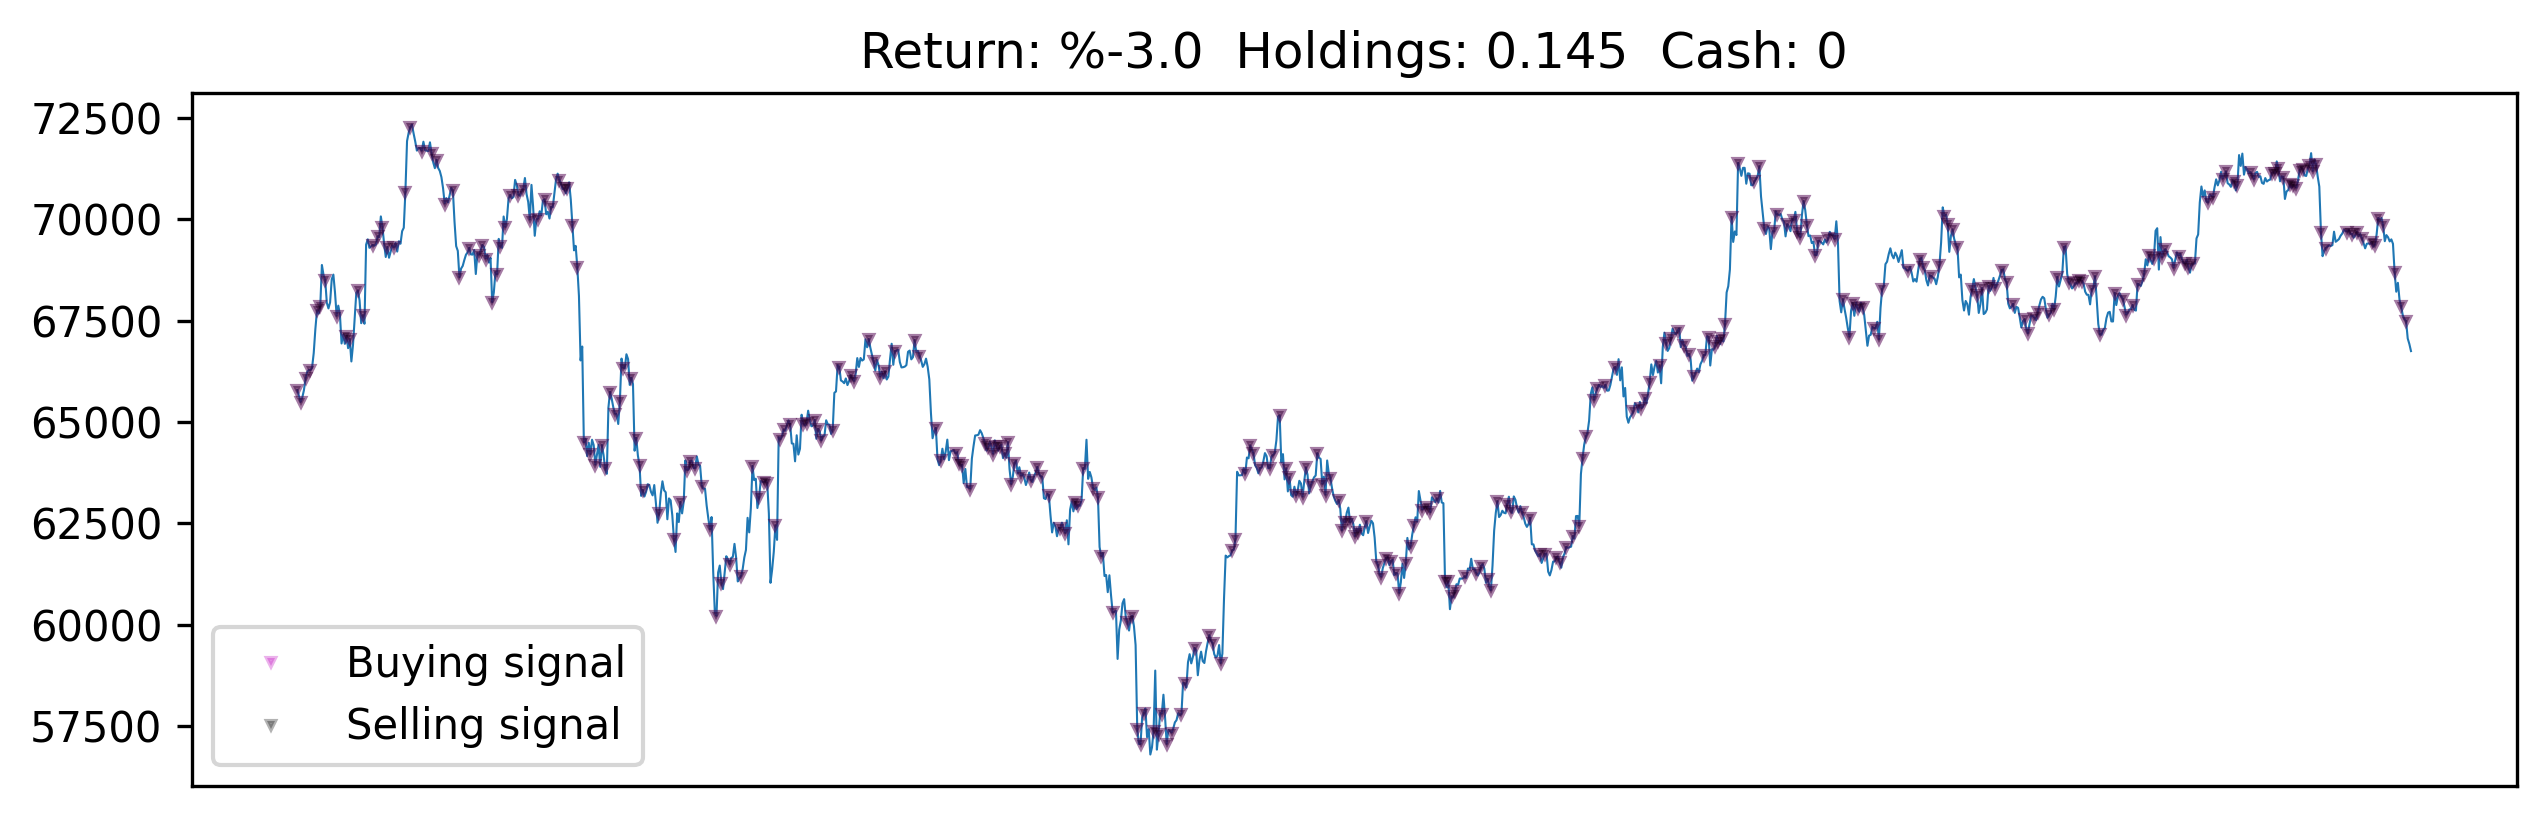

Reward = 0
Reward = 120.81706059437779
Reward = 70.12547942387148
Reward = 151.87427574127437
Reward = 0
Reward = 1.516722143971205
Reward = 0
Reward = 0
Reward = 0
Reward = 73.99020878403893
Reward = 0
Reward = 0
Reward = 5.630840938375162
Reward = 31.181480104253346
Reward = 0
Reward = 0
Reward = 0
Reward = 5.608234671683098
Reward = 178.42141490167103
Reward = 20.0528258767557
Reward = 0
Reward = 20.01009931184048
Reward = 0
Reward = 0
Reward = 0
Reward = 0
Reward = 21.55152801377113
Reward = 0
Reward = 0
Reward = 0
Reward = 0
Reward = 0
Reward = 0
Reward = 71.57775805127109
Reward = 0
Reward = 0
Reward = 6.921063395794214
Reward = 0
Reward = 0
Reward = 0
Reward = 0
Reward = 0
Reward = 0
Reward = 0
Reward = 0
Reward = 0
Reward = 0
Reward = 284.995575913293
Reward = 0
Reward = 197.54471297173188
Reward = 49.67569948997551
Reward = 0
Reward = 0
Reward = 0
Reward = 27.195895979998337
Reward = 69.32224580734314
Reward = 0
Reward = 0
Reward = 140.19504324396965
Reward = 1.246101126187652

In [ ]:
# First step --> initialize TradingEnvironment with data
print('Initializing Trading Environment...')
env = ql_environment.TradingEnvironment(test_data)
print('Trading Environment initiated')
# Second step --> initialize DQNAgent(state_size, n_categories, action_size, batch_size)
print('Initializing Agent...')
dqn_agent = ql_agent.DQNAgent(test_data.shape[1], test_data['Category'].nunique(),
                              action_space=env.action_space, batch_size=40, is_eval=False)
print('Agent initiated')
start = time.time()
print(f'Initiated training at time {start}')
train_dqn(dqn_agent, env, episodes=500, replay=False, batch_size=40)
end = time.time()
ex_time = end-start
print(f'Execution time: {ex_time/60} min')

In [9]:
data_folder = os.path.join(os.getcwd(), 'Data')
file_path_1 = os.path.join(data_folder,'q_table100_-1.0.npy')
file_path_2 = os.path.join(data_folder,'q_table400_41.81.npy')
q_table_1 = np.load(file_path_1)
q_table_2 = np.load(file_path_2)

print(q_table_1)
print(q_table_2)



[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
